# 1 Introduction

Data analysis is based on features, and different features are needed according to the data type. For text mining, we investigate the feature representation of text data. In this section, we'll be working on generating different types of text representation for a set of documents and see their performance. 

## How to Run the Module

Throughout this module you will encounter both text and code cells. Please run each cell in this Notebook by clicking "Run" button in the Toolbar or by pushing Shift+Enter keys
<br>
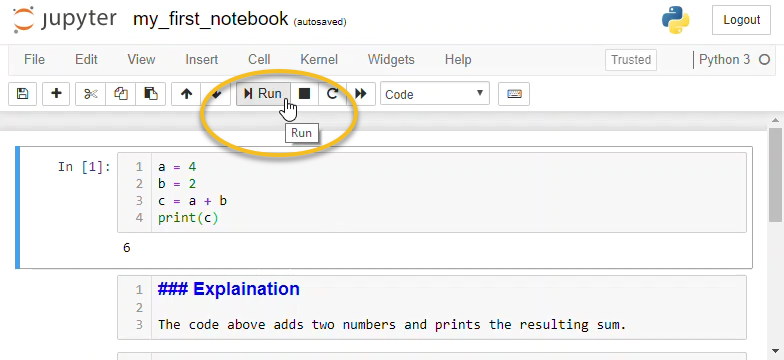

The cell below is an example of a code cell. You will be running numerous code cells like the one below throughout the case. Select the cell and select the run button above. 

In [ ]:
# This is an example of a code cell
print('Congratulations!')
print('You\'ve run your first code cell.')

## Introduction Video

Please run the code cell below to reveal the introduction video. 

In [68]:
# Set Up
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import HTML

# Display Video
HTML('<iframe width="705" height="537" src="https://edpuzzle.com/embed/media/5ec42a899daeb23eef0db888" frameborder="0" allowfullscreen></iframe>')

# 2 Bag of Words Representation

## 2.1 Video

In [67]:
from IPython.display import HTML

HTML('<iframe width="800" height="560" src="https://edpuzzle.com/embed/media/5ec2c75790f4983f549b5603" frameborder="0" allowfullscreen></iframe>')

## 2.2 Code for Preparing Sample Dataset

First of all, let's create a demo dataset using the techniques learned above. The dataset we'll be using is the Brown corpus. The Brown Corpus was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on. NLTK has samples of documents from the Brown corpus. For a complete list, see http://icame.uib.no/brown/bcm-los.html).

In [ ]:
import pandas as pd
import nltk

#Downloading the Brown corpus from nltk.corpus
nltk.download('brown')
from nltk.corpus import brown

#show an example of categories in Brown
print('Categories in Brown Corpus are: ')
brown.categories()

Since each of the genre contains only one large text while we need multiple and small chunks (for saving processing time) of text to build the demo dataset, we heuristically pick several pieces of texts from each of the selected categories in Brown corpus. Here we set the number as 3, which indicates that we are picking three pieces of text from each selected category(genre).

In [ ]:
#defining the function of picking (defaultly three) chunks of text. 
def pick_sents_brown(genre, number_of_sections=3):
    output_list = []
    sents = brown.sents(categories=genre)
    interval = len(sents)/(2*number_of_sections)
    while interval >= 50:
        interval = interval/2
    interval = int(interval)
    i=0
    j=0
    while j < number_of_sections:
        sents_picked = sents[i*interval:(i*interval+interval)]
        text = ''
        for sent in sents_picked:
            text += ' '.join(sent)
            text += ' '
        output_list.append(text)
        i=i+2
        j=j+1
    return output_list

#defining the function of turning the texts into our ideal dataset format.
#'news','romance','learned' are set to be default values. You can change them 
#to the ones you are interested in as long as they are available in 
#the sample Brown corpus in NLTK
def generate_dataset(categories=['news','romance','learned']):
    output_list = []
    for item in categories:
        sample_list = pick_sents_brown(item)
        for text in sample_list:
            dict_ = {'topic':item, 'abstract': text}
            output_list.append(dict_)
    return output_list

print('Functions have been successfully defined!')

We pick "news", "romance", and "learned" as the categories to study this time as they sound diverse. You can also try other genres if you are interested.

In [ ]:
brown_samples = generate_dataset(['news','romance','learned'])

print("Dataset generated!")

As we picked three genres and and three chunks of texts from each of the genre, the sample list has 9 items in total. 

In [ ]:
print('The total number of the texts in the sample list is ' + str(len(brown_samples)) + '. ')
print(' ')
print("Here is the sample data: ")
print(' ')
pd.DataFrame(brown_samples)

## 2.3 How to Clean the Dataset

Then we process the texts using the functions you have seen in the previous modules. 

In [ ]:
#We define the functions for text preprocessing
from contractions import CONTRACTION_MAP
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

print('Functions have been successfully defined!')

After defining the functions for expanding contractions, removing stopwords, and lemmatizing, we apply them to our texts and added the result list of words into our demo dataset.

In [ ]:
#adding seperated words into the original sample list
df_samples_list = brown_samples
for item in df_samples_list:
    new_abs = item['abstract']
    new_abs = expand_contractions(new_abs, contraction_mapping=CONTRACTION_MAP)
    new_abs = remove_special_characters(new_abs, remove_digits=True)
    new_abs_words = new_abs.split()
    new_abs_words = [lemmatizer.lemmatize(w).lower() for w in new_abs_words if w.lower() not in stop]
    item['words'] = new_abs_words

pd.DataFrame(df_samples_list)

## 2.4 How to Generate Bag of Words Representations

To make the term-document matrix, we need to find all unique words in our dataset. 

In [ ]:
#finding all unique words
all_words = []
for item in df_samples_list:
    new_abs_words =item['words']
    all_words += new_abs_words
all_words_unique = list(set(all_words))

print('There are ' + str(len(all_words_unique)) + ' unique words in our dataset.')

For each chunk of text and each term, mark '1' if it contains the term and mark '0' if it doesn't. 

In [ ]:
#making document term matrix
word_matrix = {}
for word in all_words_unique:
    word_vec = []
    for item in df_samples_list:
        if word in item['words']:
            word_vec += [1]
        else:
            word_vec += [0]
    word_matrix[word] = word_vec

dc_df = pd.DataFrame(word_matrix)
dc_df

# 3 Vector Space

## 3.1 Vector and Vector Space

### 3.1.1 Introduction to Vectors

The word matrix we made above is a good example as the integration of a set of vectors. 

In [73]:
from IPython.display import HTML

HTML('<iframe width="800" height="560" src="https://edpuzzle.com/embed/media/5ec2c898ef84173f7fef2466" frameborder="0" allowfullscreen></iframe>')

In [ ]:
dc_df

Extracting a vector from the whole matrix:

In [ ]:
print("The vector for document 0 is: ")
pd.DataFrame(dc_df.loc[0,:]).transpose()

## 3.2 How to Caculate Distance between Vectors

### 3.2.1 Video of Vector Distance/Similarity Calculation using Euclidean Distance

In [65]:
from IPython.display import HTML

HTML('<iframe width="800" height="560" src="https://edpuzzle.com/embed/media/5ec408390032e93f0486b0f4" frameborder="0" allowfullscreen></iframe>')

### 3.2.2 Video of Vector Distance/Similarity Calculation using Cosine Similarity

In [81]:
from IPython.display import HTML

HTML('<iframe width="800" height="560" src="https://edpuzzle.com/embed/media/5ec80882b5f46e3e9359ee97" frameborder="0" allowfullscreen></iframe>')

### 3.3.3 How to Calculate Distance/Similarity between Vectors

Now let's try to calculate similarity between every pair of documents using the matrix we generated above. We'll be using cosine similarity(https://en.wikipedia.org/wiki/Cosine_similarity) in the following exmaples (which is more commonly used in real world). You can also try to use Euclidean distance as an alternative to see if there is any difference. The following code imports the packages for calculating cosine similarity as well as euclidean distance.

Note: Euclidean distance measures the distance, which means that the larger the number is, the far away the two vectors are (less simiar). On the contrary, cosine similarity measures the similarity, which means that the larger the number is (one is the maximum), the similar the two vectors are.

Code for Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cos_matrix = cosine_similarity(dc_df)

pd.DataFrame(cos_matrix)

Code for Euclidean Distance

In [ ]:
#sample code for euclidean distance

euc_matrix = euclidean_distances(dc_df)

pd.DataFrame(euc_matrix)

Finding the document that has the highest similarity to the selected document. Here we choose the eighth document as an example. 

In [ ]:
#specify the index of your chosen document
chosen_doc = 8
scores = sorted(cos_matrix[chosen_doc],reverse=True) 
score = scores[1]                                     
result_doc = list(cos_matrix[chosen_doc]).index(score)
# note: you may want to change cos_matrix to euc_matrix and set reverse=False when you are using 
#       Euclidean distance since the smaller the Euclidean distance is, the similar the two documents are.
       
print('The document that is the most similar with document ' + str(chosen_doc) + ' is ' + 'document ' + str(result_doc) + '.')

The results shows that document 7 was the one that is most similar to document 8, which makes sense as they are in the same category. If you investigate the matrix a little bit more, you will see that the documents in the same category have the highest similarity. 

# 4 Term Weighting

## 4.1 Video

In [63]:
from IPython.display import HTML

HTML('<iframe width="800" height="560" src="https://edpuzzle.com/embed/media/5ec4086302f7f83f08846a53" frameborder="0" allowfullscreen></iframe>')

C:\Users\mengq\anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 4.2 Code for Different Term Weighting Strategies

Then we compute the term frequency(TF) matrix.

In [ ]:
#tf
tf_matrix = {}
tf_ranking ={}
for word in all_words_unique:
    word_vec = []
    for item in df_samples_list:
        if word in item['words']:
            word_vec += [item['words'].count(word)/len(item['words'])]
        else:
            word_vec += [0]
    tf_matrix[word] = word_vec

pd.DataFrame(tf_matrix)

Showing the term ranking according to the term frequency(TF) score.

In [ ]:
def top_terms(matrix_df, n=10): #input should be a pandas dataframe
    output_dict = {}
    for index, series in matrix_df.iterrows():
        doc_num = 'doc' + str(index)
        scores = dict(series)
        scores_sorted = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
        terms = scores_sorted.keys()
        terms_topn = list(terms)[:n]
        output_dict[doc_num] = terms_topn
    output_df = pd.DataFrame(output_dict)
    return output_df.transpose()

matrix_df = pd.DataFrame(tf_matrix)
tf_ranking = top_terms(matrix_df, 10)
tf_ranking

Computing the inverse document frequency(IDF) matrix.

In [ ]:
import math

#idf
idf_matrix = {}
for word in word_matrix:
    idf_matrix[word] = math.log(len(df_samples_list)/sum(word_matrix[word]))

print("Inverse Document Frequency Matrix successfully computed!")

Showing the term ranking according to the inverse document frequency(IDF) score.

In [ ]:
idf_ranking = {k: v for k, v in sorted(idf_matrix.items(), key=lambda item: item[1], reverse=True)}
idf_ranking

In [ ]:
#tfidf
tfidf = {}
for word in idf_matrix:
    idf = idf_matrix[word]
    tfidf_vec = tf_matrix[word]
    tfidf[word] = [i * idf for i in tfidf_vec]

pd.DataFrame(tfidf)

Finding the terms that have the highest tfidf score and showing the ranking of the terms according to tfidf.

In [ ]:
tfidf_df = pd.DataFrame(tfidf)
top_tfidf_terms = top_terms(tfidf_df)

top_tfidf_terms

These time we can find the most similar document of a chosen document using the tfidf matrix. We don't expect much improvement here since the results calculated from the simple word-document matrix were pretty good as the demo dataset is small and diverse.

In [ ]:
dc_df = pd.DataFrame(tfidf)
cos_matrix = cosine_similarity(dc_df)

pd.DataFrame(cos_matrix)

Again, we take document 8 as an example and see the document that is the most similar to document 8.

In [ ]:
#specify the index of your chosen document
chosen_doc = 8
scores = sorted(cos_matrix[chosen_doc],reverse=True)
score = scores[1]
result_doc = list(cos_matrix[chosen_doc]).index(score)

print('The document that is the most similar with document ' + str(chosen_doc) + ' is ' + 'document ' + str(result_doc) + '.')

# Exercise

Here we define a new dataset using the Medical dataset in module 1 for you to practice. 

Tips: When writting code, be careful about the variable names.

In [ ]:
# loading dataset in Module 1.
import csv 

medical_data_list = []
with open('epc-ir_clean_10k.csv') as medical_data:
    medical_data_csv = csv.reader(medical_data)
    for row in medical_data_csv:
        if(row[1] != 'topic'):
            topic = row[1]
            pmid = row[2]
            abstract = row[4]
            words = row[5].split()
            data = {'topic':topic, 'pmid':pmid, 'abstract':abstract}
            medical_data_list.append(data)
            
            
import pandas as pd
df = pd.DataFrame(medical_data_list)
print('Examples in the medical dataset:')
df.head()        
    

We are not going to use all of the data since it will take long to run for such a big amount of data. The new dataset will be composed of 10 articles from each of the topic in the medical dataset. The fnctions for data cleaning is re-defined here for your convinience. 

In [ ]:
#We define the functions for text preprocessing
from contractions import CONTRACTION_MAP
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

print('Functions have been successfully defined!')

#getting 10 articles from each of the topic in the medical dataset 
current_topic = ''
counter_in_topic = 0
med_samples = []
for index, series in df.iterrows():
    if series['topic'] != current_topic:
        counter_in_topic = 0
        current_topic = series['topic']
    else:
        counter_in_topic += 1
    
    if counter_in_topic < 10:
        new_row = {'topic':current_topic, 'abstract':series['abstract']}
        med_samples.append(new_row)   

for item in med_samples:
    new_abs = item['abstract']
    new_abs = expand_contractions(new_abs, contraction_mapping=CONTRACTION_MAP)
    new_abs = remove_special_characters(new_abs, remove_digits=True)
    new_abs_words = new_abs.split()
    new_abs_words = [lemmatizer.lemmatize(w).lower() for w in new_abs_words if w.lower() not in stop]
    item['words'] = new_abs_words
        
df_samples_list = med_samples
pd.DataFrame(med_samples)

Please following the steps specified below and using the functions we defined above to finish the task. The first step of data preprocessing has been given as an example.

In [ ]:
#expanding contractions, removing stopwords, and lemmatizing
#then adding seperated words into the original sample list
#sample code
for item in med_samples:
    new_abs = item['abstract']
    new_abs = expand_contractions(new_abs, contraction_mapping=CONTRACTION_MAP)
    new_abs = remove_special_characters(new_abs, remove_digits=True)
    new_abs_words = new_abs.split()
    new_abs_words = [lemmatizer.lemmatize(w).lower() for w in new_abs_words if w.lower() not in stop]
    item['words'] = new_abs_words

pd.DataFrame(med_samples)

In [ ]:
#finding all unique words

#your code here

In [ ]:
#finding all unique words
#sample code
all_words = []
for item in med_samples:
    new_abs_words =item['words']
    all_words += new_abs_words
all_words_unique_med = list(set(all_words))

print('There are ' + str(len(all_words_unique_med)) + ' unique words in our dataset.')

In [ ]:
#making document term matrix

#your code here

In [ ]:
#making document term matrix
#sample code
word_matrix_med = {}
for word in all_words_unique_med:
    word_vec = []
    for item in med_samples:
        if word in item['words']:
            word_vec += [1]
        else:
            word_vec += [0]
    word_matrix_med[word] = word_vec

pd.DataFrame(word_matrix_med)

In [ ]:
#Computing the term frequency(TF) matrix (for calculating tfidf).
#your code here

In [ ]:
#Computing the term frequency(TF) matrix (for calculating tfidf).
#sample code
tf_matrix_med = {}
for word in all_words_unique_med:
    word_vec = []
    for item in med_samples:
        if word in item['words']:
            word_vec += [item['words'].count(word)/len(item['words'])]
        else:
            word_vec += [0]
    tf_matrix_med[word] = word_vec
    
pd.DataFrame(tf_matrix_med)

In [ ]:
#Computing the inverse document frequency(IDF) matrix.

#your code here

In [ ]:
#Computing the inverse document frequency(IDF) matrix.
#sample code
import math

#idf
idf_matrix_med = {}
for word in word_matrix_med:
    idf_matrix_med[word] = math.log(len(med_samples)/sum(word_matrix_med[word]))

idf_matrix_med

In [ ]:
#Computing the tf-idf matrix.

#your code here

In [ ]:
#Computing the tf-idf matrix.
#sample
tfidf_med = {}
for word in idf_matrix_med:
    idf = idf_matrix_med[word]
    tfidf_vec = tf_matrix_med[word]
    tfidf_med[word] = [i * idf for i in tfidf_vec]

pd.DataFrame(tfidf_med)

In [ ]:
#finding the terms that have the highest tf-idf score

#your code here

In [ ]:
#finding the terms that have the highest tf-idf score
#sample code
def top_terms(matrix_df, n=10): #input should be a pandas dataframe
    output_dict = {}
    for index, series in matrix_df.iterrows():
        doc_num = 'doc' + str(index)
        scores = dict(series)
        scores_sorted = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
        terms = scores_sorted.keys()
        terms_topn = list(terms)[:n]
        output_dict[doc_num] = terms_topn
    output_df = pd.DataFrame(output_dict)
    return output_df.transpose()

tfidf_med_df=pd.DataFrame(tfidf_med)

top_tfidf_terms_med = top_terms(tfidf_med_df)
top_tfidf_terms_med

In [ ]:
#calculating the scores of cosine similarity using tfidf

#your code here

In [ ]:
#calculating the scores of cosine similarity using tfidf
#sample code
from sklearn.metrics.pairwise import cosine_similarity

dc_df_med = pd.DataFrame(tfidf_med)
cos_matrix_med = cosine_similarity(dc_df_med)

pd.DataFrame(cos_matrix_med)

In [ ]:
#Find the document that is the most similar to document 1. Is it under the same topic of document 1 (with in the first 10 (0-9) documents)?

#your code here

In [ ]:
#Find the document that is the most similar to document 1. Is it under the same topic of document 1 (with in the first 10 (0-9) documents)?
#sample code

chosen_doc = 1
scores = sorted(cos_matrix_med[chosen_doc],reverse=True)
score = scores[1]
result_doc = list(cos_matrix_med[chosen_doc]).index(score)

print('The document that is the most similar with document ' + str(chosen_doc) + ' is ' + 'document ' + str(result_doc) + '.')